## ДЗ №3 Двухуровневый пайплайн
#### В этой домашке вам предстоит написать с нуля двустадийную рекомендательную систему. 

#### Дата выдачи: 10.03.25

#### Мягкий дедлайн: 31.03.25 23:59 MSK

#### Жесткий дедлайн: 7.04.25 23:59 MSK

### Описание
Это творческое задание, в котором вам необходимо реализовать полный цикл построения рекомендательной системы: реализовать кандидат генераторов, придумать и собрать признаки, обучить итоговый ранкер и заинференсить модели на всех пользователей.

Вам предоставляется два набора данных: `train.csv` и `test.csv` 

In [1]:
import pandas as pd

In [2]:
train = pd.read_csv('train_part.csv')
test = pd.read_csv('test_part.csv')

display(train.head())
print('_' * 60)
test.head()

,user_id,item_id,last_watch_dt,total_dur,watched_pct,target
0,310745,13373,2021-03-13,4485,98.0,1
1,952323,15997,2021-03-13,7507,100.0,1
2,889459,11460,2021-03-13,60,0.0,0
3,854016,11237,2021-03-13,5381,98.0,1
4,307257,9132,2021-03-13,5814,100.0,1


____________________________________________________________


,user_id,item_id,last_watch_dt,total_dur,watched_pct,target
0,718866,6382,2021-08-13,10309,19.0,0
1,147119,13865,2021-08-13,1666,26.0,0
2,1079425,4141,2021-08-13,774,10.0,0
3,810008,15297,2021-08-13,3,0.0,0
4,1068123,10440,2021-08-13,492,0.0,0


In [3]:
train = train.sort_values('last_watch_dt')
split_index = int(0.8 * len(train))
train_stage_1 = train.iloc[:split_index].reset_index(drop=True)
valid_stage_1 = train.iloc[split_index:].reset_index(drop=True)



### 1 Этап. Модели первого уровня. (max 3 балла)
В этом этапе вам необходимо разделить `train` датасет на 2 части: для обучения моделей первого уровня и для их валидации. Единственное условие для разбиения – разбивать нужно по времени. Данные для обучение будем называть `train_stage_1`, данные для валидации `valid_stage_1`. Объемы этих датасетов вы определяет самостоятельно. 

Для начала нам нужно отобрать кандидатов при помощи легких моделей. Необходимо реализовать 3 типа моделей:
1. Любая эвристическая(алгоритмичная) модель на ваш выбор **(0.5 балл)**
2. Любая матричная факторизация на ваш выбор **(1 балл)**
3. Любая нейросетевая модель на ваш выбор **(1 балла)**

Не забудьте использовать скор каждой модели, как признак!



In [4]:
from models import HeuristicModel, MatrixFactorization, NeuralRecSysModel

In [5]:
example_user = train_stage_1['user_id'].iloc[0]
example_item = train_stage_1['item_id'].iloc[0]

In [6]:
my_heuristic_model = HeuristicModel()
my_heuristic_model.fit(train_stage_1)

score = my_heuristic_model.predict(example_user, example_item)
print(f"Прогноз релевантности для пользователя {example_user} и айтема {example_item}: {score}")

recommended_items = my_heuristic_model.recommend(example_user, k=10)
print("Топ-10 рекомендуемых айтемов:", recommended_items)

Прогноз релевантности для пользователя 310745 и айтема 13373: 298
Топ-10 рекомендуемых айтемов: [15297, 13865, 10440, 9728, 3734, 4151, 142, 8636, 6809, 11237]


In [7]:
my_matrix_factorization = MatrixFactorization(n_factors=20, learning_rate=0.01, reg=0.1, n_epochs=1, random_state=42, default_score=0.0)
my_matrix_factorization.fit(train_stage_1)

predicted_score = my_matrix_factorization.predict(example_user, example_item)
print(f"Прогноз для пользователя {example_user} и айтема {example_item}: {predicted_score}")

recommended_items = my_matrix_factorization.recommend(example_user, k=10)
print("Топ-10 рекомендуемых айтемов:", recommended_items)

Прогноз для пользователя 310745 и айтема 13373: 0.5265961297175779
Топ-10 рекомендуемых айтемов: [1264, 599, 8832, 1024, 13622, 512, 12719, 11940, 9465, 9714]


In [8]:
my_neural_network = NeuralRecSysModel(embedding_dim=20, hidden_dim=64, lr=0.01, n_epochs=1, default_score=0.0)
my_neural_network.fit(train_stage_1)

score = my_neural_network.predict(example_user, example_item)
print(f"Прогноз релевантности для пользователя {example_user} и айтема {example_item}: {score}")

recommended_items = my_neural_network.recommend(example_user, k=10)
print("Топ-10 рекомендуемых айтемов:", recommended_items)

Прогноз релевантности для пользователя 310745 и айтема 13373: 0.5225228667259216
Топ-10 рекомендуемых айтемов: [9259, 4433, 3610, 2192, 9465, 2270, 1933, 2494, 11103, 6572]


Каждая модель должна уметь:
1) для пары user_item предсказывать скор релевантности (масштаб скора не важен), важно обработать случаи, когда модель не можеn проскорить пользователя или айтем, вместо этого вернуть какое-то дефолтное значение
2) для всех пользователей вернуть top-k самых релевантных айтемов (тут вам скоры не нужны)


Дополнительно можно провести анализ кандидат генератов, измерить насколько различные айтемы они рекомендуют, например с помощью таких метрик как: [Ranked based overlap](https://github.com/changyaochen/rbo) или различные вариации [Diversity](https://github.com/MaurizioFD/RecSys2019_DeepLearning_Evaluation/blob/master/Base/Evaluation/metrics.py#L289). **(1 балл)**

In [9]:
from utils import compute_diversity

recommendations = {
    "heuristic": my_heuristic_model.recommend(example_user, k=10),
    "mf": my_matrix_factorization.recommend(example_user, k=10),
    "nn": my_neural_network.recommend(example_user, k=10),
}

print(f"Diversity между рекомендациями от моделей: {compute_diversity(recommendations)}")

Diversity между рекомендациями от моделей: 0.9666666666666667


Все модели, которые мы рассмотрели, выдают разные рекомендации


### 2 Этап. Генерация и сборка признаков. (max 2 балла)
Необходимо собрать минимум 10 осмысленных (`np.radndom.rand()` не подойдет) признаков, при этом:
1. 2 должны относиться только к сущности "пользователь" (например средний % просмотра фильмов у этой возрастной категории)
2. 2 должны относиться только к сущности "айтем" (например средний средний % просмотра данного фильма)
3. 6 признаков, которые показывают связь пользователя и айтема (например средний % просмотра фильмов с данным актером (айтем) у пользователей с таким же полом (пользователь)). 

### ВАЖНО!  

1. **В датасете есть колонка `watched_prct`. Ее можно использовать для генерации признаков (например сколько пользователь в среднем смотрит фильмы), но нельзя подавать в модель, как отдельную фичу, потому что она напрямую связана с target.**
2. **Все признаки должны быть собраны без дата лика, то есть если пользователь посмотрел фильм 10 августа, то признаки мы можем считать только на данных до 9 августа включительно.**


### Разбалловка
Обучение ранкера будет проходить на `valid_stage_1`, как  раз на которой мы валидировали модели, а тестировать на `test`. Поэтому есть 2 варианта сборки признаков, **реализовать нужно только 1 из них:**
1. Для обучения собираем признаки на первый день `valid_stage_1`, а для теста на первый день `test`. Например, если `valid_stage_1` начинается 5 сентября, то все признаки мы можем собирать только по 4 сентября включительно. **(1 балл)**
2. Признаки будем собирать честно на каждый день, то есть на 5 сентября собираем с начала до 4, на 6 сентября с начала до 5 и т.д. **(2 балла)**

In [10]:
train['last_watch_dt'] = pd.to_datetime(train['last_watch_dt'])
valid_stage_1['last_watch_dt'] = pd.to_datetime(valid_stage_1['last_watch_dt'])
test['last_watch_dt'] = pd.to_datetime(test['last_watch_dt'])

valid_day_1 = valid_stage_1['last_watch_dt'].min()
test_day_1 = test['last_watch_dt'].min()

# для формирования признаков используем данные до дня, предшествующего первому дню
cutoff_valid = valid_day_1 - pd.Timedelta(days=1)
cutoff_test = test_day_1 - pd.Timedelta(days=1)
history_valid = train[train['last_watch_dt'] <= cutoff_valid].copy()
history_test = pd.concat([train, valid_stage_1]).copy()
history_test = history_test[history_test['last_watch_dt'] <= cutoff_test].copy()

Соберем признаки по пользователю 

In [11]:
user_agg_valid = history_valid.groupby('user_id').agg(
    user_interaction_count=('user_id', 'count'),
    user_avg_watched_pct=('watched_pct', 'mean')
).reset_index()

user_agg_test = history_test.groupby('user_id').agg(
    user_interaction_count=('user_id', 'count'),
    user_avg_watched_pct=('watched_pct', 'mean')
).reset_index()

По айтему

In [12]:
item_agg_valid = history_valid.groupby('item_id').agg(
    item_interaction_count=('item_id', 'count'),
    item_avg_watched_pct=('watched_pct', 'mean')
).reset_index()

item_agg_test = history_test.groupby('item_id').agg(
    item_interaction_count=('item_id', 'count'),
    item_avg_watched_pct=('watched_pct', 'mean')
).reset_index()

Для юзер-айтем

In [13]:
user_item_agg_valid = history_valid.groupby(['user_id', 'item_id']).agg(
    user_item_interaction_count=('user_id', 'count'),
    user_item_avg_total_dur=('total_dur', 'mean'),
    user_item_avg_watched_pct=('watched_pct', 'mean'),
    user_item_total_dur_sum=('total_dur', 'sum')
).reset_index()

user_item_agg_test = history_test.groupby(['user_id', 'item_id']).agg(
    user_item_interaction_count=('user_id', 'count'),
    user_item_avg_total_dur=('total_dur', 'mean'),
    user_item_avg_watched_pct=('watched_pct', 'mean'),
    user_item_total_dur_sum=('total_dur', 'sum')
).reset_index()

# ratio-признаки: 
user_item_agg_valid = user_item_agg_valid.merge(user_agg_valid, on='user_id', how='left')
user_item_agg_valid['user_ratio'] = user_item_agg_valid['user_item_interaction_count'] / user_item_agg_valid['user_interaction_count']

user_item_agg_valid = user_item_agg_valid.merge(item_agg_valid, on='item_id', how='left')
user_item_agg_valid['item_ratio'] = user_item_agg_valid['user_item_interaction_count'] / user_item_agg_valid['item_interaction_count']

user_item_agg_test = user_item_agg_test.merge(user_agg_test, on='user_id', how='left')
user_item_agg_test['user_ratio'] = user_item_agg_test['user_item_interaction_count'] / user_item_agg_test['user_interaction_count']

user_item_agg_test = user_item_agg_test.merge(item_agg_test, on='item_id', how='left')
user_item_agg_test['item_ratio'] = user_item_agg_test['user_item_interaction_count'] / user_item_agg_test['item_interaction_count']

interaction_cols = [
    'user_id', 'item_id', 
    'user_item_interaction_count', 
    'user_item_avg_total_dur', 
    'user_item_avg_watched_pct', 
    'user_item_total_dur_sum', 
    'user_ratio', 'item_ratio'
]
user_item_agg_valid = user_item_agg_valid[interaction_cols]
user_item_agg_test = user_item_agg_test[interaction_cols]

Объединяем данные

In [14]:
train_df_with_features = valid_stage_1.copy()

train_df_with_features = train_df_with_features.merge(user_agg_valid, on='user_id', how='left')
train_df_with_features = train_df_with_features.merge(item_agg_valid, on='item_id', how='left')
train_df_with_features = train_df_with_features.merge(user_item_agg_valid, on=['user_id', 'item_id'], how='left')

interaction_feature_cols = ['user_item_interaction_count', 'user_item_avg_total_dur',
                              'user_item_avg_watched_pct', 'user_item_total_dur_sum',
                              'user_ratio', 'item_ratio']
train_df_with_features[interaction_feature_cols] = train_df_with_features[interaction_feature_cols].fillna(0)

test_df_with_features = test.copy()

test_df_with_features = test_df_with_features.merge(user_agg_test, on='user_id', how='left')
test_df_with_features = test_df_with_features.merge(item_agg_test, on='item_id', how='left')
test_df_with_features = test_df_with_features.merge(user_item_agg_test, on=['user_id', 'item_id'], how='left')
test_df_with_features[interaction_feature_cols] = test_df_with_features[interaction_feature_cols].fillna(0)

print("Размерность Train (valid_stage_1):", train_df_with_features.shape)
print("Размерность теста:", test_df_with_features.shape)

Размерность Train (valid_stage_1): (973392, 16)
Размерность теста: (608467, 16)


Был использован первый вариант 1: для обучения все признаки собираются на основе истории до дня, предшествующего первому дню valid_stage_1, а для теста — на основе истории до дня, предшествующего первому дню test

Пользовательские признаки (2):

1. user_interaction_count – количество взаимодействий пользователя в истории

2. user_avg_watched_pct – средний процент просмотра (watched_pct) для пользователя в истории

Признаки айтема (2):

3. item_interaction_count – количество взаимодействий с айтемом в истории

4. item_avg_watched_pct – средний процент просмотра для айтема в истории

Признаки взаимодействия пользователь–айтем (6):

5. user_item_interaction_count – число взаимодействий данного пользователя с данным айтемом

6. user_item_avg_total_dur – среднее время просмотра (total_dur) для данной пары

7. user_item_avg_watched_pct – средний watched_pct для данной пары

8. user_item_total_dur_sum – суммарное время просмотра для данной пары

9. user_ratio – отношение числа взаимодействий пользователя с данным айтемом к общему числу взаимодействий этого пользователя

10. item_ratio – отношение числа взаимодействий пользователя с данным айтемом к общему числу взаимодействий с этим айтемом


### 3 Этап. Обучение финального ранкера (max 2 балла)
Собрав все признаки из этапа 2, добавив скоры моделей из этапа 1 для каждой пары пользователь-айтем (где это возможно), пришло время обучать ранкер. В качестве ранкера можно использовать либо [xgboost](https://xgboost.readthedocs.io/en/stable/) или [catboost](https://catboost.ai/). Обучать можно как `Classfier`, так и `Ranker`, выбираем то, что лучше сработает. Обучение ранкера будет проходить на `valid_stage_1`, как  раз на которой мы валидировали модели, а тестировать на `test`, которую мы до сих пор не трогали.  Заметьте, что у нас в тесте есть холодные пользователи – те, кого не было в train и активные – те, кто был в train. Возможно их стоит обработать по отдельности (а может и нет).  
(1 балл)

После получения лучшей модели надо посмотреть на важность признаков и [shap values](https://shap.readthedocs.io/en/latest/index.html), чтобы:
1. Интерпритировать признаки, которые вы собрали, насколько они полезные
2. Проверить наличие ликов – если важность фичи в 100 раз больше, чем у всех остальных, то явно что-то не то  

(1 балл)






In [15]:
import xgboost as xgb
import shap
from utils import add_model_scores

train_df_with_features = add_model_scores(train_df_with_features, my_heuristic_model, my_matrix_factorization, my_neural_network)
test_df_with_features = add_model_scores(test_df_with_features, my_heuristic_model, my_matrix_factorization, my_neural_network)

feature_cols = [
    'user_interaction_count', 'user_avg_watched_pct',
    'item_interaction_count', 'item_avg_watched_pct',
    'user_item_interaction_count', 'user_item_avg_total_dur', 'user_item_avg_watched_pct', 'user_item_total_dur_sum',
    'user_ratio', 'item_ratio',
    'heuristic_score', 'mf_score', 'nn_score'
]

target_col = 'target'

X_train = train_df_with_features[feature_cols]
y_train = train_df_with_features[target_col]

X_test = test_df_with_features[feature_cols]
y_test = test_df_with_features[target_col]

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [16]:
ranker = xgb.XGBClassifier(n_estimators=100, max_depth=5, learning_rate=0.1, random_state=42)
ranker.fit(X_train, y_train)

example_user = test_df_with_features['user_id'].iloc[0]
user_test_data = test_df_with_features[test_df_with_features['user_id'] == example_user].copy()
user_features = user_test_data[feature_cols]
user_preds = ranker.predict_proba(user_features)[:, 1]
user_test_data['ranker_score'] = user_preds
user_test_data = user_test_data.sort_values(by='ranker_score', ascending=False)
print("Топ-10 рекомендаций для пользователя", example_user)
print(user_test_data[['item_id', 'ranker_score']].reset_index(drop=True))

Топ-10 рекомендаций для пользователя 718866
   item_id  ranker_score
0     4151      0.353642
1     6382      0.207837
2     3877      0.153489


/var/folders/h9/0y8pddws5r74cd3l8tn5h53m0000gn/T/ipykernel_5386/2333365617.py:4: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_train)


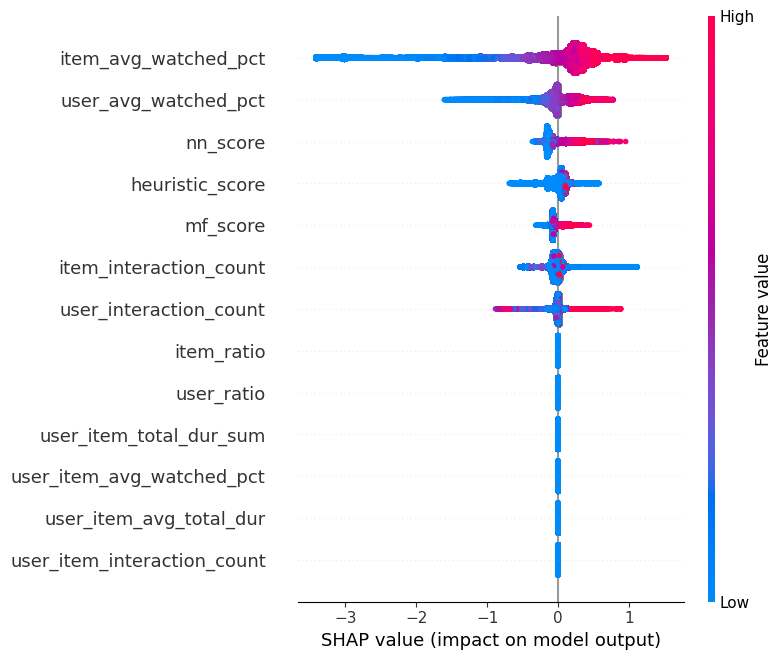

In [17]:
explainer = shap.Explainer(ranker)
shap_values = explainer(X_train)

shap.summary_plot(shap_values, X_train)

В итоге, глобальные признаки, отражающие общую активность пользователя и популярность айтема (например, user_avg_watched_pct и item_avg_watched_pct), а также интегрированные скоры от моделей первого уровня (эвристической, MF и нейронной) оказались наиболее информативными и полезными для финального ранкера. Эти фичи дают стабильный сигнал о вовлеченности пользователей и качестве контента

Локальные признаки, характеризующие конкретное взаимодействие пользователя с айтемом (например, число взаимодействий, суммарное и среднее время просмотра, а также соотношения), в сравнении с глобальными показателями показали меньшую важность. Возможно, они либо избыточны, либо сильно коррелируют с более общими метриками, поэтому их вклад в итоговое предсказание невелик


### 4 Этап. Инференс лучшего ранкера (max 3 балла)

Теперь мы хотим построить рекомендации "на завтра", для этого нам нужно:

1. Обучить модели первого уровня на всех (train+test) данных (0.5 балла)
2. Для каждой модели первого уровня для каждого пользователя сгененировать N кандидатов (0.5 балла)
3. "Склеить" всех кандидатов для каждого пользователя (дубли выкинуть), посчитать скоры от всех моделей (0.5 балла)
4. Собрать фичи для ваших кандидатов (теперь можем считать признаки на всех данных) (0.5 балла)
5. Проскорить всех кандидатов бустингом и оставить k лучших (0.5 балла)
6. Посчитать разнообразие(Diversity) и построить график от Diversity(k) (0.5 балла)


Все гиперпараметры (N, k) определяете только Вы!

In [18]:
full_data = pd.concat([train, test], ignore_index=True)

my_heuristic_model.fit(full_data)
my_matrix_factorization.fit(full_data)
my_neural_network.fit(full_data)

In [19]:
import numpy as np

N = 50

all_users = full_data['user_id'].unique()
np.random.seed(42)
sample_size = int(0.025 * len(all_users)) # разрешили инференс не на всей выборке, а то даже гпушки с трудом вывозят
sampled_users = np.random.choice(all_users, size=sample_size, replace=False)

heuristic_candidates = {}
for user in sampled_users:
    recs = my_heuristic_model.recommend(user, k=N)
    heuristic_candidates[user] = recs

In [20]:
mf_candidates = {}
for user in sampled_users:
    recs = my_matrix_factorization.recommend(user, k=N)
    mf_candidates[user] = recs

In [21]:
nn_candidates = {}
for user in sampled_users:
    recs = my_neural_network.recommend(user, k=N)
    nn_candidates[user] = recs

In [22]:
combined_candidates = {}
for user in sampled_users: 
    candidates = set(heuristic_candidates.get(user, [])) | set(mf_candidates.get(user, [])) | set(nn_candidates.get(user, []))
    combined_candidates[user] = list(candidates)

user_list = []
item_list = []
for user, items in combined_candidates.items():
    for item in items:
        user_list.append(user)
        item_list.append(item)

user_array = np.array(user_list)
item_array = np.array(item_list)

In [23]:
def predict_batch(model, users, items):
    preds = [model.predict(u, i) for u, i in zip(users, items)]
    return np.array(preds)

heuristic_preds = predict_batch(my_heuristic_model, user_array, item_array)
mf_preds = predict_batch(my_matrix_factorization, user_array, item_array)
nn_preds = predict_batch(my_neural_network, user_array, item_array)

candidates_df = pd.DataFrame({
    'user_id': user_array,
    'item_id': item_array,
    'heuristic_score': heuristic_preds,
    'mf_score': mf_preds,
    'nn_score': nn_preds
})

In [24]:
user_feats = full_data.groupby('user_id').agg(
    user_interaction_count=('user_id', 'count'),
    user_avg_watched_pct=('watched_pct', 'mean')
).reset_index()

item_feats = full_data.groupby('item_id').agg(
    item_interaction_count=('item_id', 'count'),
    item_avg_watched_pct=('watched_pct', 'mean')
).reset_index()

ui_feats = full_data.groupby(['user_id', 'item_id']).agg(
    user_item_interaction_count=('user_id', 'count'),
    user_item_avg_total_dur=('total_dur', 'mean'),
    user_item_avg_watched_pct=('watched_pct', 'mean'),
    user_item_total_dur_sum=('total_dur', 'sum')
).reset_index()

ui_feats = ui_feats.merge(user_feats, on='user_id', how='left')
ui_feats['user_ratio'] = ui_feats['user_item_interaction_count'] / ui_feats['user_interaction_count']
ui_feats = ui_feats.merge(item_feats, on='item_id', how='left')
ui_feats['item_ratio'] = ui_feats['user_item_interaction_count'] / ui_feats['item_interaction_count']
ui_feats = ui_feats[['user_id', 'item_id', 
                     'user_item_interaction_count', 'user_item_avg_total_dur',
                     'user_item_avg_watched_pct', 'user_item_total_dur_sum',
                     'user_ratio', 'item_ratio']]

candidates_with_feats = candidates_df.merge(user_feats, on='user_id', how='left')
candidates_with_feats = candidates_with_feats.merge(item_feats, on='item_id', how='left')
candidates_with_feats = candidates_with_feats.merge(ui_feats, on=['user_id', 'item_id'], how='left')
for col in ['user_item_interaction_count', 'user_item_avg_total_dur', 
            'user_item_avg_watched_pct', 'user_item_total_dur_sum', 'user_ratio', 'item_ratio']:
    candidates_with_feats[col] = candidates_with_feats[col].fillna(0)

final_feature_cols = [
    'user_interaction_count', 'user_avg_watched_pct',
    'item_interaction_count', 'item_avg_watched_pct',
    'user_item_interaction_count', 'user_item_avg_total_dur',
    'user_item_avg_watched_pct', 'user_item_total_dur_sum',
    'user_ratio', 'item_ratio',
    'heuristic_score', 'mf_score', 'nn_score'
]

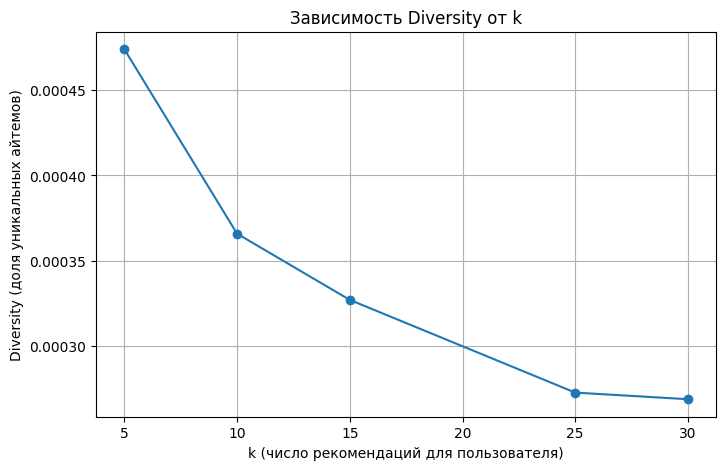

In [26]:
import matplotlib.pyplot as plt

X_candidates = candidates_with_feats[final_feature_cols]
candidates_with_feats['final_score'] = ranker.predict_proba(X_candidates)[:, 1]

k = 8
final_recs = candidates_with_feats.sort_values(['user_id', 'final_score'], ascending=[True, False])
final_recs_by_user = final_recs.groupby('user_id').head(k)

k_values = [5, 10, 15, 25, 30]
diversity_scores = []
for k_val in k_values:
    recs_dict = {}
    for user, group in final_recs.groupby('user_id'):
        topk = group.sort_values('final_score', ascending=False).head(k_val)['item_id'].tolist()
        recs_dict[user] = topk
    diversity = compute_diversity(recs_dict)
    diversity_scores.append(diversity)

plt.figure(figsize=(8, 5))
plt.plot(k_values, diversity_scores, marker='o')
plt.xlabel('k (число рекомендаций для пользователя)')
plt.ylabel('Diversity (доля уникальных айтемов)')
plt.title('Зависимость Diversity от k')
plt.grid(True)
plt.show()

На графике видно, что по мере увеличения числа рекомендаций k доля уникальных товаров среди всех рекомендаций уменьшается. При выдаче большего количества позиций растёт пересечение рекомендуемых айтемов разным пользователям и, как следствие, падает разнообразие